# Korteweg-de Vries equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the Korteweg-de Vries equation. 

Set the noise level, number of samples, architecture and strength of the $L_1$ Penalty

In [1]:
import numpy as np
import pandas as pd 

from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import library_1D
from deepymod.utilities import library_matrix_mat, print_PDE

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(42)  # setting seed for randomisation

## Prepare the data

Next, we prepare the dataset.

In [2]:
data = np.load('data/kdv.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (512, 201)


Let's plot it to get an idea of the data:

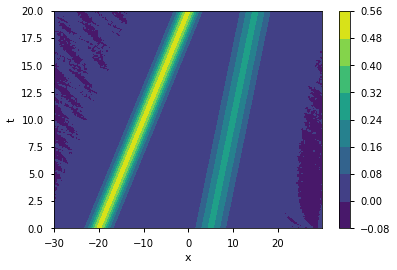

In [3]:
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], np.real(data['u']))
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [4]:
X = np.transpose((data['x'].flatten(), data['t'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))

print(X.shape, y.shape)

(102912, 2) (102912, 1)


As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [5]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 2000 samples:

In [6]:
number_of_samples = 1000

idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y_noisy[idx, :][:number_of_samples]

We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

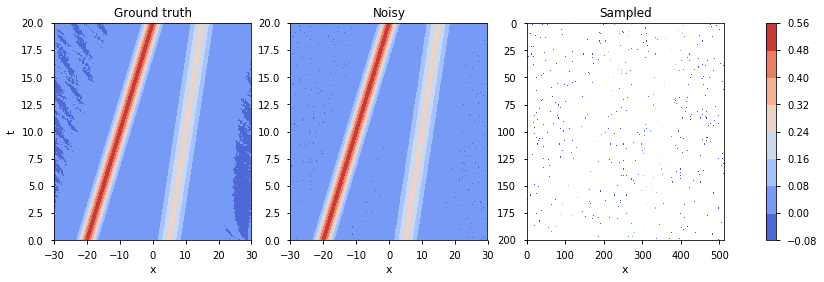

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Configure the neural network

We now setup the options for DeepMoD. There's as few dictionaries to fill, starting with 'config', which sets up the the general network layers and L$_1$ penalty. We use the following:

In [8]:
config = {'layers': [2, 20, 20, 20, 20, 20, 1], 'lambda': 10e-6}

Next we set the training options. Usually we only change the maximum iterations and the grad_tol, which sets the convergence criterion;

In [9]:
train_opts = {'max_iterations': 20000, 'grad_tol':10**-7, 'learning_rate': 0.002, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}

DeepMoD accepts any arbitrary library function and any options for it can be given through *the library_config*. The library function for this example accepts a maximum order for the polynomial and derivative terms. DeepMoD also needs to know the total number of terms upfront. We can calculate that by making a list of the polynomial and derivative terms and getting all the terms by feeding them into the library_matrix_mat function. Its output will be used later to print the found PDE.

In [10]:
u = ['1', 'u', 'uˆ2']
du = ['1', 'u_{x}', 'u_{xx}', 'u_{xxx}']
coeffs_list = library_matrix_mat(u, du)

print(coeffs_list)

library_config = {'total_terms': len(coeffs_list), 'deriv_order': 3, 'poly_order': 2}

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'uˆ2', 'uˆ2u_{x}', 'uˆ2u_{xx}', 'uˆ2u_{xxx}']


The last configuration we need to fill is the ouput_opts. It contains an output_directory and X_predict field. We've build a custom tensorboard so you can follow the progress of the run.  Output_directory sets where the files are saved, then simply run 

`tensorboard --logdir $[OUTPUT_DIRECTORY]`

in a terminal to open tensorboard. It shows the value of the coefficients, scaled coefficients and all possible costs. Note that the runs are timestamped in output_directory, so you'll have to add it! We can also use the output of tensorboard to analyze deepmod after. We show this below. The last option is X_predict. As DeepMoD also denoises the data, use this option to denoise some dataset X after DeepMoD has converged.

In [11]:
output_opts = {'output_directory': 'output/burgers/', 'X_predict': X}

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We also need to specify which library function we wish to use. You can build any library you want and just pass is through this command:

In [12]:
sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_1D, library_config, train_opts, output_opts)

Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [0.59844595, 0.012143345, 0.03649929, 0.56183606, 0.00011058643]
500 [0.017280467, 0.0008246411, 0.01365739, 0.003542878, 8.0197635e-05]
1000 [0.007692895, 0.0003051667, 0.0063986643, 0.0011447447, 0.00014948579]
1500 [0.006816086, 0.00046630114, 0.0054706945, 0.0012328458, 0.000112545706]
2000 [0.0061532785, 0.00055087375, 0.0048074387, 0.0012451045, 0.00010073495]
2500 [0.0056804577, 0.00043784844, 0.004504157, 0.0010848064, 9.1494236e-05]
3000 [0.0053056804, 0.00047241076, 0.0041766097, 0.0010415456, 8.7525295e-05]
3500 [0.0048427177, 0.00044476453, 0.0038137352, 0.00094592787, 8.3054234e-05]
4000 [0.004501195, 0.00041666673, 0.003577137, 0.0008459331, 7.8125435e-05]
4500 [0.004195904, 0.0004019875, 0.0033961462, 0.0007283125, 7.1445094e-05]
5000 [0.0037246996, 0.00026619332, 0.0031362, 0.00052883115, 5.966869e-05]
5500 [0.0033118161, 0.00024248492, 0.0029053634, 0.0003590006, 4.745204e-05]
6000 [0.0029341863, 0.000178471, 0.0027

Now that DeepMoD has converged, it has found the following equation:

In [13]:
print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 1.002u_{xxx} - 6.011uu_{x}


which is correct! Let's analyse a few more results in the next section.

## Analysis

Plot the 'Ground truth', 'Noisy' and 'Reconstructed/Denoised' solution

In [15]:
data= {'x_grid': X[:, 0], 't_grid': X[:, 1], 'ground truth': y, 'noisy': y_noisy, 'inferred': denoised}
for key in data:
    data[key] = np.squeeze(data[key])
data = pd.DataFrame(data)
train_idx = np.random.permutation(data['t_grid'].size)[:number_of_samples]
data['train set'] = [data['noisy'][index] if index in train_idx else None for index in np.arange(data['t_grid'].size)]

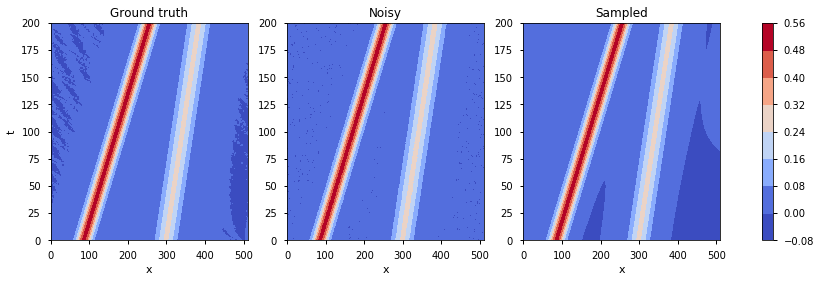

In [18]:
vmin = data['ground truth'].min()
vmax =data['ground truth'].max()

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data.pivot(index='t_grid', columns='x_grid', values='ground truth'), cmap='coolwarm',vmin=vmin, vmax=vmax)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data.pivot(index='t_grid', columns='x_grid', values='noisy'), cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

im2 = axes[2].contourf(data.pivot(index='t_grid', columns='x_grid', values='inferred'), cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()